# Kaggle 2018 Data Science Bowl

## Predictions using a simple Convolutional Neural Network

In [1]:
# import the necessary packages
from glob import glob
#import imageio
import numpy as np

from keras.preprocessing.image import img_to_array
import os
import pandas as pd
import pathlib
import skimage

from skimage import data, filters, io, transform
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.io import imread
from scipy import ndimage

import matplotlib.pyplot as plt
%matplotlib inline

import imgaug as ia
from imgaug import augmenters as iaa


c:\users\wstra\.virtualenvs\nuclei-vxu5rk9n\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# class DataPrep:  loading and preparing the data for a stage

Looks at stage1 by default.

In [2]:

use_saved_weights = True

IMG_CHANNELS = 3

def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0

class DataPrep:
    
    def __init__(self, data_directory = os.path.join('..', 'data'), stage_label = 'stage1'):
        self.data_dir = data_directory
        self.stage_label = stage_label
        self.train_labels = None
        self.img_df = None
        self.train_img_df = None

    def load_stage_properties(self, verbose = False):
        # Create a DataFrame containing all stage image (both training and test, both images and masks) paths, 
        #   IDs, and properties
        all_images = glob(os.path.join(self.data_dir, '{}_*'.format(self.stage_label), '*', '*', '*'))
        self.img_df = pd.DataFrame({'path': all_images})
        img_id = lambda in_path: in_path.split(os.sep)[-3]
        img_type = lambda in_path: in_path.split(os.sep)[-2]
        img_group = lambda in_path: in_path.split(os.sep)[-4].split('_')[1]
        img_stage = lambda in_path: in_path.split(os.sep)[-4].split('_')[0]
        self.img_df['ImageId'] = self.img_df['path'].map(img_id)
        self.img_df['ImageType'] = self.img_df['path'].map(img_type)
        self.img_df['TrainingSplit'] = self.img_df['path'].map(img_group)
        self.img_df['Stage'] = self.img_df['path'].map(img_stage)
        if verbose:
            print(self.img_df.sample(2))
                
    def load_training_labels(self, verbose = False):
        # Read the training labels from CSV
        self.train_labels = pd.read_csv(os.path.join(self.data_dir,'{}_train_labels.csv'.format(self.stage_label)))
        # Turn the encoded pixels into Python lists
        self.train_labels['EncodedPixels'] = self.train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
        if verbose:
            print(self.train_labels.sample(3))

    def load_training_images(self, verbose = False):
        # This may take a minute...
        # Get the images in the training split
        train_df = self.img_df.query('TrainingSplit=="train"')
        self.train_rows = []
        group_cols = ['Stage', 'ImageId']
        i = 0
        for n_group, n_rows in train_df.groupby(group_cols):
#             print('n_group={0}, n_rows={1}'.format(n_group, n_rows))
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
#             print('len(masks)={}'.format(len(c_row['masks'])))
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
#             print(c_row['images'])
            self.train_rows += [c_row]
        self.train_img_df = pd.DataFrame(self.train_rows) # so far, images and masks are lists of paths
        # The following reads the images into arrays, drops the Alpha channel, and divides each 0-255 intensity by 255
        self.train_img_df['images'] = self.train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
        # The following reads the masks and creates a single mask array per image with entries 0 and 1
        self.train_img_df['masks'] = self.train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
#         print('images.shape={0}, masks.shape={1}'.format(self.train_img_df['images'], self.train_img_df['masks']))
        if verbose:
            print(self.train_img_df.sample(1))
        
    def display_sample_images(self):
        # Display some samples
        n_img = 6
        fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
        for (_, c_row), (c_im, c_lab) in zip(self.train_img_df.sample(n_img).iterrows(), 
                                             m_axs.T):
            c_im.imshow(c_row['images'])
            c_im.axis('off')
            c_im.set_title('Image')

            c_lab.imshow(c_row['masks'])
            c_lab.axis('off')
            c_lab.set_title('Masks')
    
    def count_training_image_shapes(self):
        print(self.train_img_df['images'].map(lambda x: x.shape).value_counts())

    def load_stage2_test_data(self, verbose = False):
        # Add stage2 test images to the DataFrame
        all_images2 = glob(os.path.join(self.data_dir, 'stage2_*', '*', '*', '*'))
        img_df2 = pd.DataFrame({'path': all_images2})
        img_id = lambda in_path: in_path.split(os.sep)[-3]
        img_type = lambda in_path: in_path.split(os.sep)[-2]
        img_group = lambda in_path: in_path.split(os.sep)[-4].split('_')[1]
        img_stage = lambda in_path: in_path.split(os.sep)[-4].split('_')[0]
        img_df2['ImageId'] = img_df2['path'].map(img_id)
        img_df2['ImageType'] = img_df2['path'].map(img_type)
        img_df2['TrainingSplit'] = img_df2['path'].map(img_group)
        img_df2['Stage'] = img_df2['path'].map(img_stage)
        combo = self.img_df.append(img_df2)
        self.img_df = combo
        if verbose:
            print(self.img_df.sample(5))

### Load the Stage1 data

### First, training labels

In [3]:
dp = DataPrep()
dp.load_training_labels(verbose=True)

                                                 ImageId  \
20627  abc781c8721fe04b877a7e324494eb75aa5bce94950a0e...   
20803  ad9d305cbf193d4250743ead466bdaefe910835d7e352c...   
15316  7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a...   

                                           EncodedPixels  
20627           [35351, 3, 35605, 6, 35861, 6, 36117, 6]  
20803  [40700, 10, 41211, 13, 41722, 15, 42233, 18, 4...  
15316  [51747, 5, 52001, 8, 52255, 11, 52510, 13, 527...  


### Load ImageIds, paths, etc.

In [4]:
dp.load_stage_properties(verbose=False)

### A sample row of the image properties dataframe

In [5]:
dp.img_df.iloc[2]

path             ..\data\stage1_test\0a849e0eb15faa8a6d7329c3dd...
ImageId          0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...
ImageType                                                   images
TrainingSplit                                                 test
Stage                                                       stage1
Name: 2, dtype: object

### Load the training images and masks
This takes a minute...

In [6]:
dp.load_training_images(verbose=True)

                                               ImageId   Stage  \
644  f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d...  stage1   

                                                images  \
644  [[[0.011764705882352941, 0.011764705882352941,...   

                                                 masks  
644  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  


### Sample images and masks

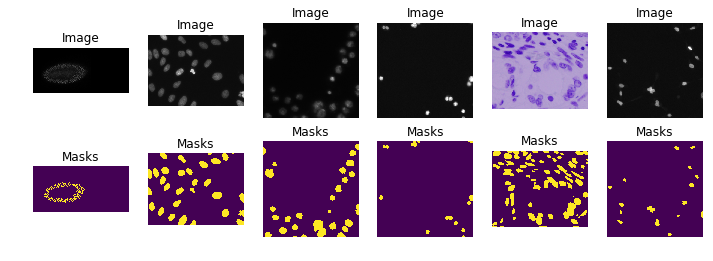

In [7]:
dp.display_sample_images()

### Counts of shapes for the training images

In [8]:
dp.count_training_image_shapes()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64


### A few sample rows of the images dataframe

In [9]:
dp.train_img_df.sample(3)

,ImageId,Stage,images,masks
165,3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075...,stage1,"[[[0.054901960784313725, 0.054901960784313725,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
570,da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e751...,stage1,"[[[0.12549019607843137, 0.12549019607843137, 0...","[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
211,4e07a653352b30bb95b60ebc6c57afbc7215716224af73...,stage1,"[[[0.8156862745098039, 0.8156862745098039, 0.8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### The images column of the dataframe contains 3-channel arrays with intensities normalized to the range 0-1. The masks column contains one binary array per image with the masks marked.

In [10]:
print(dp.train_img_df['images'][2].shape)
print(dp.train_img_df['masks'][2].shape)

(256, 320, 3)
(256, 320)


### How to query for a specific image's properties

In [11]:
dp.img_df.query('TrainingSplit == "train"' and 
                'ImageId == "00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e"')

,path,ImageId,ImageType,TrainingSplit,Stage
130,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,images,train,stage1
131,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
132,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
133,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
134,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
135,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
136,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
137,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
138,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
139,..\data\stage1_train\00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1


### Getting a specific image's image and mask arrays

In [12]:
dp.train_img_df.query('TrainingSplit == "train"' and 
                      'Stage == "stage1"' and
                      'ImageId == "00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e"')

,ImageId,Stage,images,masks
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,stage1,"[[[0.5098039215686274, 0.24313725490196078, 0....","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,..."


# class SimpleCNN:   defining/training/running a simple Convolutional Neural Network for the prediction task.

In [21]:
class SimpleCNN:
    
    def __init__(self):
        self.IMG_CHANNELS = 3
        self.simple_cnn = None
        self.test_img_df = None

    def define_keras_model(self, verbose = False):
        # Set up a fairly simple Keras CNN
        from keras import backend as K
        from keras.models import Sequential
        from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
        self.simple_cnn = Sequential()
        self.simple_cnn.add(BatchNormalization(input_shape = (None, None, self.IMG_CHANNELS), 
                                          name = 'NormalizeInput'))
        self.simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
        self.simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))

        # use dilations to get a slightly larger field of view
        self.simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
        self.simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
        self.simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

        # the final processing
        self.simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
        self.simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
        if verbose:
            print(self.simple_cnn.summary())
            
        smooth = 1.

        def dice_coef(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)
            return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

        def dice_coef_loss(y_true, y_pred):
            return -dice_coef(y_true, y_pred)

        self.simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

    def define_keras_model_2(self, verbose = False):
        # Set up a Keras CNN, slightly larger than the first model
        from keras import backend as K
        from keras.models import Sequential
        from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
        self.simple_cnn = Sequential()
        self.simple_cnn.add(BatchNormalization(input_shape = (None, None, self.IMG_CHANNELS), 
                                          name = 'NormalizeInput'))
        self.simple_cnn.add(Conv2D(16, kernel_size = (3,3), padding = 'same'))
        self.simple_cnn.add(Conv2D(16, kernel_size = (3,3), padding = 'same'))

        # use dilations to get a slightly larger field of view
        self.simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
        self.simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
        self.simple_cnn.add(Conv2D(64, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

        # the final processing
        self.simple_cnn.add(Conv2D(32, kernel_size = (1,1), padding = 'same'))
        self.simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
        if verbose:
            print(self.simple_cnn.summary())
            
        smooth = 1.

        def dice_coef(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)
            return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

        def dice_coef_loss(y_true, y_pred):
            return -dice_coef(y_true, y_pred)

        self.simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])
    
    def learn_the_model(self, train_img_df, use_saved_weights = False, epochs = 3):
        def simple_gen():
            while True:
                for _, c_row in train_img_df.iterrows():
                    yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)
                    
        def aug_gen():
            augmentor = iaa.SomeOf((0, 2), [
                iaa.Fliplr(1.0),  # horizontal flip
                iaa.Flipud(1.0),  # vertical flip
                iaa.Affine(rotate=(-15, 15)),
                iaa.Affine(shear=(-20, 20)),
                iaa.Multiply((0.5, 1.5), per_channel=0.5),  # lighten or darken
                ])
            seq = iaa.Sequential(augmentor,
                         random_order=True)
            seq_copy = seq.deepcopy()
            aug_seed = 0
            while True:
                seq.reseed(aug_seed)
                seq_copy.reseed(aug_seed)
                for _, c_row in train_img_df.iterrows():
                    image = c_row['images']
                    masks = np.expand_dims(c_row['masks'],-1)
                    new_image = seq.augment_image(image)
                    new_masks = seq_copy.augment_image(masks)
                    yield np.expand_dims(new_image,0), np.expand_dims(new_masks,0)
                aug_seed += 1
                

        # Learn the model 
        if not use_saved_weights:
            # This takes a while...
            self.simple_cnn.fit_generator(aug_gen(), 
                                     steps_per_epoch = train_img_df.shape[0],
                                     epochs = epochs)
            
    def save_weights(self, filename = 'keras_weights.h5'):
        # Save the model so we don't have to retrain it to use it
        import h5py
        from keras.models import load_model
        self.simple_cnn.save_weights(filename)
        
    def load_saved_weights(self, filename = 'keras_weights.h5'):
        import h5py
        from keras.models import load_model
        self.simple_cnn.load_weights(filename)
        
#     def prep_stage2_tests(self, img_df):
#         # Prepare to run the stage2 tests
#         test_df = img_df.query('TrainingSplit=="test" and Stage=="stage2"')
#         test_rows = []
#         group_cols = ['Stage', 'ImageId']
#         for n_group, n_rows in test_df.groupby(group_cols):
#             c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
#             c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
#             # One image has only one intensity channel, which will cause read_and_stack to fail.
#             # Until I can fix that, I'll just take it out of the mix. I'll add a dummy entry for
#             #  it in the submission CSV file. Won't affect the score much.
#             if '646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0' not in c_row['images'][0]:
#                 test_rows += [c_row]

#         self.test_img_df = pd.DataFrame(test_rows)    
#         self.test_img_df['images'] = self.test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
        
#     def run_stage2_tests(self):
#         # This takes almost 15 minutes...
#         # Generate the model's predictions for the stage2 test images
#         self.test_img_df['masks'] = self.test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])        
                
    def prep_stage_tests(self, img_df, stage_label):
        # Prepare to run the tests
        test_df = img_df.query('TrainingSplit=="test" and Stage=="{}"'.format(stage_label))
        test_rows = []
        group_cols = ['Stage', 'ImageId']
        for n_group, n_rows in test_df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            # One image has only one intensity channel, which will cause read_and_stack to fail.
            # Until I can fix that, I'll just take it out of the mix. I'll add a dummy entry for
            #  it in the submission CSV file. Won't affect the score much.
#             print(c_row['images'])
            if len(c_row['images']) == 0:
                continue
            if '646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0' not in c_row['images'][0]:
                test_rows += [c_row]

        self.test_img_df = pd.DataFrame(test_rows)    
        self.test_img_df['images'] = self.test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
        
    def run_stage_tests(self):
        # This takes almost 15 minutes...
        # Assumes you've run prep_stage_tests for the stage of interest.
        # Generate the model's predictions for the stage's test images.
        self.test_img_df['masks'] = self.test_img_df['images'].map(lambda x: self.simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])
    

In [22]:
test_df = dp.img_df.query('TrainingSplit=="test" and Stage=="stage1"')
test_df.shape

(65, 5)

### Create the CNN model

In [23]:
cnn = SimpleCNN()
cnn.define_keras_model(verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 16)    528       
__________

### Learn the model

This takes a while.
After learning, save the weights, which can then be used on subsequent runs to skip the training step, e.g., to try out different post-processing steps.

In [24]:
%%time
use_saved_weights = False
if not use_saved_weights:
    cnn.learn_the_model(dp.train_img_df, use_saved_weights=False, epochs=3)

Epoch 1/3
343/670 [==============>...............] - ETA: 3:23 - loss: -0.5833 - dice_coef: 0.5833 - acc: 0.8718 - mean_squared_error: 0.1266

KeyboardInterrupt: 

### Save the weights

In [17]:
if not use_saved_weights:
    cnn.save_weights('simple_cnn_weights_v1_3_epochs.h5')

### Load saved weights

In [18]:
use_saved_weights = True
if use_saved_weights:
    cnn.load_saved_weights('simple_cnn_weights_v1_3_epochs.h5')

### Prepare data for a prediction run

In [19]:
cnn.prep_stage_tests(dp.img_df, 'stage1')

### Do a prediction run

In [20]:
%%time
cnn.run_stage_tests()

Wall time: 15.8 s


In [108]:
cnn.test_img_df.sample(1)

,ImageId,Stage,images,masks
56,da6c593410340b19bb212b9f6d274f95b08c0fc8f2570c...,stage1,"[[[0.5450980392156862, 0.4823529411764706, 0.7...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


# class PostProcess:  post-process the results of a prediction run

In [109]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation
from skimage.morphology import closing, opening, disk
from skimage.morphology import label # to label regions

class PostProcess:
    
    def __init__(self):
        pass
    
    def clean_img(self, img):
        return opening(closing(img, disk(1)), disk(3))

    def clean_test_results(self, test_img_df):
        # This can take a little while...
        test_img_df['rles'] = test_img_df['masks'].map(self.clean_img).map(lambda x: list(self.prob_to_rles(x))) 
        return test_img_df
    
    def display_samples_cleaned(self, test_img_df):
        n_img = 3
        fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
        for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
            c_im.imshow(d_row['images'])
            c_im.axis('off')
            c_im.set_title('Image')

            c_lab.imshow(d_row['masks'])
            c_lab.axis('off')
            c_lab.set_title('Predicted')

            c_clean.imshow(self.clean_img(d_row['masks']))
            c_clean.axis('off')
            c_clean.set_title('Cleaned')    

    def rle_encoding(self, x):
        '''
        x: numpy array of shape (height, width), 1 - mask, 0 - background
        Returns run length as list
        '''
        dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right, which is what Kaggle expects
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev+1): run_lengths.extend((b+1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths

    def prob_to_rles(self, x, cut_off = 0.5):
        lab_img = label(x > cut_off)
        if lab_img.max() < 1:
            lab_img[0,0] = 1 # ensure at least one prediction per image
        for i in range(1, lab_img.max() + 1):
            yield self.rle_encoding(lab_img == i)
    
    def save_predictions_file(self, test_img_df, outfile='predictions.csv'):
        out_pred_list = []
        for _, c_row in test_img_df.iterrows():
            # The model may make a prediction that consists of the entire image
            # kaggle's scoring algorithm fails on such predictions.
            # We'll replace them with a smaller prediction. That will also be wrong, but at least it won't
            #  cause kaggle scoring to fail.
            if len(c_row['rles']) == 1:
                s = c_row['images'].shape
                img_size = s[0] * s[1]
                if c_row['rles'][0][0] == 1 and c_row['rles'][0][1] == img_size:
                    c_row['rles'] = [[int(img_size/2), int(10)]]
            for c_rle in c_row['rles']:
                out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                                     EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
        out_pred_df = pd.DataFrame(out_pred_list)
        print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
        out_pred_df.sample(3)
        out_pred_df[['ImageId', 'EncodedPixels']].to_csv(outfile, index = False)

### Post-process a run

In [110]:
pp = PostProcess()
cnn.test_img_df = pp.clean_test_results(cnn.test_img_df)
cnn.test_img_df.sample(1)

,ImageId,Stage,images,masks,rles
10,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,stage1,"[[[0.13333333333333333, 0.13333333333333333, 0...","[[1.40093735e-14, 2.1806762e-14, 4.9176258e-17...","[[1046, 2, 1563, 6, 2080, 8, 2597, 11, 3116, 1..."


### Sample predictions and cleaned images

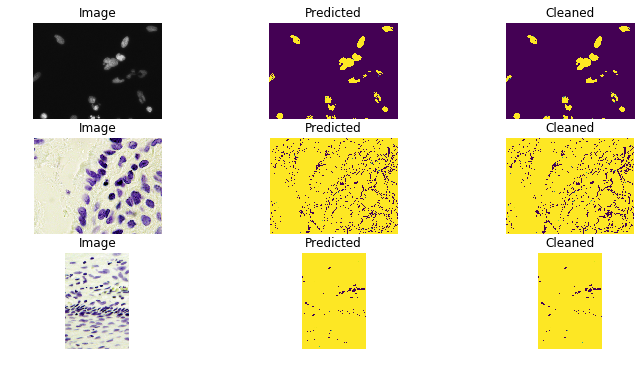

In [111]:
pp.display_samples_cleaned(cnn.test_img_df)

### Save the predictions file in Kaggle format

In [112]:
pp.save_predictions_file(cnn.test_img_df, 'predictions_v1_3_epochs.csv')

1876 regions found for 65 images


# class KaggleScorer:   Scoring a run

In [113]:
import skimage
import skimage.segmentation

class KaggleScorer:
    
    def __init__(self, test_img_df, data_directory = os.path.join('..', 'data'), stage_label = 'stage1'):
        self.data_dir = data_directory
        self.stage_label = stage_label
        self.test_img_df = test_img_df
    
    def load_ground_truth_masks(self, verbose = False):
        # Read the masks from CSV 
        self.true_masks = pd.read_csv(os.path.join(self.data_dir,'{}_solution.csv'.format(self.stage_label)))
        # Turn the encoded pixels into Python lists
        self.true_masks['EncodedPixels'] = self.true_masks['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
        if verbose:
            print(self.true_masks.sample(3))

    def load_predicted_masks(self, filepath, verbose = False):
        # Read the masks from CSV 
        self.predicted_masks = pd.read_csv(filepath)
        # Turn the encoded pixels into Python lists
        self.predicted_masks['EncodedPixels'] = self.predicted_masks['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
        if verbose:
            print(self.predicted_masks.sample(3))
    
    def create_mask_image_from_RLE(self, masks, height, width):
        img = np.zeros((height, width), np.uint16).flatten()
        mask_num = 1
        for _, m_row in masks.iterrows():
            rle = m_row['EncodedPixels']
            index = 0
            for i in range(int(len(rle) / 2)):
                where = rle[index] - 1 # indices sent to Kaggle are 1-based
                length = rle[index+1]
#                 print('  where={0}, length={1}'.format(where, length))
                for j in range(length):
                    img[where + j] = mask_num
                index += 2
            mask_num += 1
        img = img.reshape(width, height).T  # RLE uses Fortran order
        return img            

    def score_an_image(self, image_id, verbose = False):
        # Assumes we've run load_ground_truth_masks and load_predicted_masks
        if verbose:
            print()
            print('ImageId={}'.format(image_id))
        masks = ks.true_masks.query('ImageId == "{}"'.format(image_id))
        height = masks.iloc[0]['Height']
        width = masks.iloc[0]['Width']
#         print('height=', height, ' width=', width)
        true_img = ks.create_mask_image_from_RLE(masks, height, width)

        pred_masks = ks.predicted_masks.query('ImageId == "{}"'.format(image_id))
        pred_img = ks.create_mask_image_from_RLE(pred_masks, height, width)
        if verbose:
            plt.subplot(1, 3, 1)
            img = self.test_img_df.query('ImageId == "{}"'.format(image_id))['images'].iloc[0]
            plt.imshow(img)
            plt.axis('off')
            plt.title(' Original Image')
            plt.subplot(1, 3, 2)
            plt.imshow(true_img)
            plt.axis('off')
            plt.title('Ground Truth')
            plt.subplot(1, 3, 3)
            plt.imshow(pred_img)
            plt.axis('off')
            plt.title('Predictions')
            plt.show()            

        # Compute number of objects
        true_objects = len(np.unique(true_img))
        pred_objects = len(np.unique(pred_img))
        if verbose:
            print("Number of true objects:", true_objects)
            print("Number of predicted objects:", pred_objects)

        # Compute intersection between all objects
        intersection = np.histogram2d(true_img.flatten(), pred_img.flatten(), bins=(true_objects, pred_objects))[0]

        # Compute areas (needed for finding the union between all objects)
        area_true = np.histogram(true_img, bins = true_objects)[0]
        area_pred = np.histogram(pred_img, bins = pred_objects)[0]
        area_true = np.expand_dims(area_true, -1)
        area_pred = np.expand_dims(area_pred, 0)

        # Compute union
        union = area_true + area_pred - intersection

        # Exclude background from the analysis
        intersection = intersection[1:,1:]
        union = union[1:,1:]
        union[union == 0] = 1e-9

        # Compute the intersection over union
        iou = intersection / union
#         print('iou={}'.format(iou))

        # Precision helper function
        def precision_at(threshold, iou):
            matches = iou > threshold
            true_positives = np.sum(matches, axis=1) == 1   # Correct objects
            false_positives = np.sum(matches, axis=0) == 0  # Missed objects
            false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
            tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
            return tp, fp, fn

        # Loop over IoU thresholds
        prec = []
        if verbose:
            print("Thresh\tTP\tFP\tFN\tPrec.")
        for t in np.arange(0.5, 1.0, 0.05):
            tp, fp, fn = precision_at(t, iou)
            p = tp / (tp + fp + fn)
            if verbose:
                print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
            prec.append(p)
        if verbose:
            print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
        return np.mean(prec)
    
    def score_a_run(self, verbose = False):
        precisions = []
        for n_group, _ in ks.true_masks.groupby(['ImageId']):
            precisions.append(self.score_an_image(n_group, verbose=verbose))
        mean_prec = sum(precisions) / float(len(precisions))
        if verbose:
            print('Kaggle score = {0:.3f}'.format(mean_prec))
        return mean_prec

            

### Load the ground truth masks and predicted masks into the KaggleScorer

In [114]:
ks = KaggleScorer(cnn.test_img_df)
ks.load_ground_truth_masks()
ks.load_predicted_masks('predictions_v1_3_epochs.csv')

### How to retrieve and display ground truth masks for an image

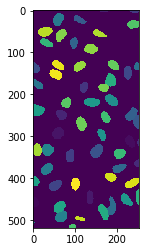

In [115]:
masks = ks.true_masks.query('ImageId == "0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac"')
height = masks.iloc[0]['Height']
width = masks.iloc[0]['Width']
mask_img = ks.create_mask_image_from_RLE(masks, height, width)
plt.imshow(mask_img)

### How to retrieve and display predictions for an image

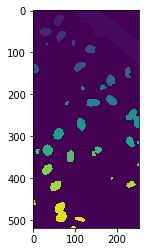

In [116]:
masks = ks.predicted_masks.query('ImageId == "0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac"')
# same height and width as true_masks image
mask_img = ks.create_mask_image_from_RLE(masks, height, width)
plt.imshow(mask_img)

### Compute the Kaggle score for an image

Note: there is no relationship between the colors in the two mask images. It's just the locations of the masks that matter. 

In [ ]:
score = ks.score_an_image('0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732', verbose=True)

### Compute the overall Kaggle score for a run

In [ ]:
ks.score_a_run(verbose=True)

### Get just the overall score

In [117]:
score = ks.score_a_run()
print('Kaggle score = {0:.3f}'.format(score))

Kaggle score = 0.138


In [ ]:
ks.true_masks.query('ImageId == "0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466"')

In [43]:
ks.predicted_masks.query('ImageId == "0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5"')

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[45106, 5, 45360, 9, 45615, 10, 45871, 11, 461..."
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[51354, 1, 51608, 5, 51863, 6, 52119, 7, 52374..."
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[38822, 1, 39076, 5, 39331, 6, 39585, 9, 39840..."


In [44]:
ks.load_predicted_masks('predictions_v1_3_epochs.csv', verbose=True)

                                                ImageId  \
927   7bdb668e6127b7eafc837a883f0648002bd063c736f55a...   
1162  bdc789019cee8ddfae20d5f769299993b4b330b2d38d12...   
507   4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...   

                                          EncodedPixels  
927   [185345, 4, 185351, 2, 185857, 10, 186369, 11,...  
1162  [243817, 6, 244329, 16, 244847, 21, 245366, 27...  
507   [43999, 1, 44387, 5, 44776, 6, 45166, 7, 45555...  
